Forma Forte do problema.

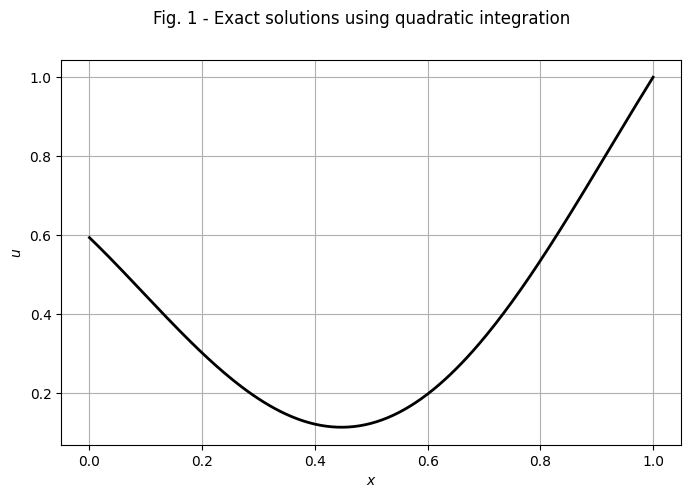

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import quad
import math

# --- input data ---
# boundary conditions
#q = 2
#h = 3

def u_e(x):
    # Exemplo: u_e(x) = x^2 + sin(pi*x) + exp(-x)
    return x**2 + np.sin(np.pi * x) + np.exp(-x)

# source f(x)
def f(x):
    #f = 5.0 # Problema original da atividade avaliativa 03
    #f = 50*math.cos(10*x) # Um problema um pouco mais interessante
    # teste aqui qualquer função f
    return 2 - (np.pi**2) * np.sin(np.pi * x) + np.exp(-x)
# A solução analítica depende da integral da função f(x) no intervalo 0-y.
# Essa integral poderia ser feita usando o pacote de integração simbólica do python.
# Entretanto, nesse exemplo ela é feita analiticamente por meio da função int_f

q = u_e(0)
h = u_e(1)


def int_f(z): # to avoid symbolic integation of f over z
    #f = 5.0*z
    #f = 50*math.sin(10*z)/10
    # para qualquer nova função f, é necessário criar a int_0^y f(z)dz
    #return f
    return 2 * z + np.pi * np.cos(np.pi * z) - np.exp(-z) - np.pi + 1

# degrees of freedom
dof = 25
samples = 201 # used to plot the figures

# --- Solution ---
# sample points
x = np.linspace(0, 1, samples)
u = np.zeros(np.size(x))

j = 0
for i in x:
    u[j] = q + (1-i)*h + quad(int_f,i,1)[0] # ,args=(f,i))[0]
    j = j+1

fig = plt.figure(figsize=(8,5))
plt.plot(x, u, 'k', linewidth=2);
plt.grid(True);
plt.xlabel('$x$');
plt.ylabel('$u$');
fig.suptitle('Fig. 1 - Exact solutions using quadratic integration');


Forma fraca do problema.



Nós usados na discretização:
[0.   0.04 0.08 0.12 0.16 0.2  0.24 0.28 0.32 0.36 0.4  0.44 0.48 0.52
 0.56 0.6  0.64 0.68 0.72 0.76 0.8  0.84 0.88 0.92 0.96 1.  ]




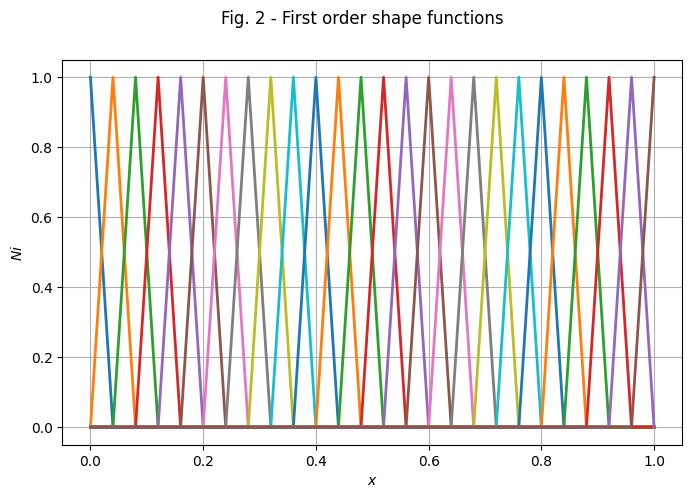

In [2]:
# 1D mesh
xi = np.linspace(0, 1, dof+1) # do not necessarily have to a linear spaced vector
np.set_printoptions(precision=3)
print("\n")
print("Nós usados na discretização:")
print(xi)
print("\n")

# first order shape function
def N(xp,xi,i):
    last_i = len(xi)-1
    if(i == 0 and xp <= xi[1]):
        y = (xi[1]-xp)/(xi[1]-xi[0])
    elif(i == last_i and xp >= xi[last_i-1]):
        y = (xp-xi[last_i-1])/(xi[last_i]-xi[last_i-1])
    elif(xp >= xi[i] and xp <= xi[i+1]):
        y = (xi[i+1]-xp)/(xi[i+1]-xi[i])
    elif(xp <= xi[i] and xp >= xi[i-1]):
        y = (xp-xi[i-1])/(xi[i]-xi[i-1])
    else:
        y = 0
    return y

# ploting shape functions
fig = plt.figure(figsize=(8,5))
for j in range(len(xi)):
    Ni = np.zeros(np.size(x))
    for i in range(len(x)):
        Ni[i] = N(x[i],xi,j)

    plt.plot(x, Ni, linewidth=2);
plt.grid(True);
plt.xlabel('$x$');
plt.ylabel('$Ni$');
fig.suptitle('Fig. 2 - First order shape functions');

Implementação das derivadas das funções de forma.

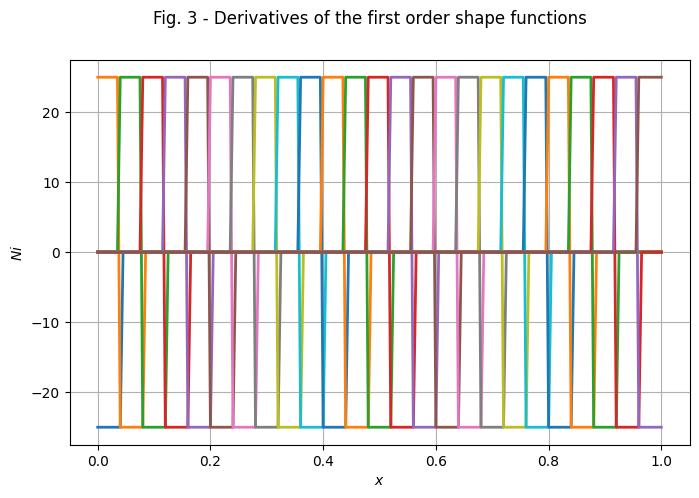

In [3]:
# derivatives of the first order shape function
def dNdx(xp,xi,i):
    last_i = len(xi)-1
    if(i == 0 and xp <= xi[1]):
        y = (-1)/(xi[1]-xi[0])
    elif(i == last_i and xp >= xi[last_i-1]):
        y = (1)/(xi[last_i]-xi[last_i-1])
    elif(xp >= xi[i] and xp <= xi[i+1]):
        y = (-1)/(xi[i+1]-xi[i])
    elif(xp <= xi[i] and xp >= xi[i-1]):
        y = (1)/(xi[i]-xi[i-1])
    else:
        y = 0
    return y

# ploting shape functions
fig = plt.figure(figsize=(8,5))
for j in range(len(xi)):
    dNidx = np.zeros(np.size(x))
    for i in range(len(x)):
        dNidx[i] = dNdx(x[i],xi,j)

    plt.plot(x, dNidx, linewidth=2);
plt.grid(True);
plt.xlabel('$x$');
plt.ylabel('$Ni$');
fig.suptitle('Fig. 3 - Derivatives of the first order shape functions');

Sistema matricial.

In [4]:
# Initializing the variables
K_AB = np.zeros([dof,dof])
F_A = np.zeros(dof)

# Bilinear operetor a(w,v)
def innerprod_a(xp,xi,a,b):
    y = dNdx(xp,xi,a)*dNdx(xp,xi,b)
    return y

# Bilinear operetor (w,f)
def innerprod(xp,xi,a):
    y = N(xp,xi,a)*f(xp)
    return y

# loop over the N_A functions
for a in range(dof):
    # loop over the N_B functions
    for b in range(dof): # cold be considerably optimized due to the kronecker delta properties
        K_AB[a,b] = quad(innerprod_a,0,1,args=(xi,a,b))[0]

    F_A[a] = quad(innerprod,0,1,args=(xi,a))[0] + N(0,xi,a)*h - q*quad(innerprod_a,0,1,args=(xi,a,dof))[0]

print("\n")
print("K_AB =")
print(K_AB)
print("\n")
print("F_A =")
print(F_A)

<ipython-input-4-60122de3f3bd>:19: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  K_AB[a,b] = quad(innerprod_a,0,1,args=(xi,a,b))[0]




K_AB =
[[ 25. -25.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
    0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.]
 [-25.  50. -25.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
    0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.]
 [  0. -25.  50. -25.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
    0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.]
 [  0.   0. -25.  50.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
    0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.]
 [  0.   0.   0.   0.  50. -25.   0.   0.   0.   0.   0.   0.   0.   0.
    0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.]
 [  0.   0.   0.   0. -25.  50. -25.   0.   0.   0.   0.   0.   0.   0.
    0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.]
 [  0.   0.   0.   0.   0. -25.  50.   0.   0.   0.   0.   0.   0.   0.
    0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.]
 [  0.   0.   0.   0.   0.   0.   0.  50. -25.   0.   0.   0.   0.   0.
    0.   

Resolvendo FDM e Erro quadratico médio.

In [5]:
def solve_fdm(n_nodes):
    """
    Resolve o problema u_xx = f(x) usando o Método de Diferenças Finitas.

    Args:
        n_nodes: Número total de nós no domínio (incluindo as extremidades).

    Returns:
        Um tuple contendo:
            - x_fdm: Array dos pontos onde a solução FDM foi calculada.
            - u_fdm: Array da solução FDM nos pontos correspondentes.
    """
    h_step = 1.0 / (n_nodes - 1)
    x_fdm = np.linspace(0, 1, n_nodes)

    # Construindo o sistema linear Ku = F
    # A matriz K será tridiagonal
    K_fdm = np.zeros((n_nodes, n_nodes))
    F_fdm = np.zeros(n_nodes)

    # Preenchendo a matriz K e o vetor F para nós internos (i = 1 to n_nodes - 2)
    for i in range(1, n_nodes - 1):
        K_fdm[i, i - 1] = 1 / (h_step**2)
        K_fdm[i, i] = -2 / (h_step**2)
        K_fdm[i, i + 1] = 1 / (h_step**2)
        F_fdm[i] = f(x_fdm[i])

    # Aplicando condições de contorno de Dirichlet
    # Nó inicial (i = 0)
    K_fdm[0, 0] = 1
    F_fdm[0] = u_e(0) # Condição de contorno u(0) = u_e(0)

    # Nó final (i = n_nodes - 1)
    K_fdm[n_nodes - 1, n_nodes - 1] = 1
    F_fdm[n_nodes - 1] = u_e(1) # Condição de contorno u(1) = u_e(1)

    # Resolvendo o sistema linear
    u_fdm = np.linalg.solve(K_fdm, F_fdm)

    return x_fdm, u_fdm

# Função para calcular o erro médio quadrático.
# %%
def mean_square_error(numerical_solution, analytical_solution):
    """
    Calcula o erro médio quadrático entre duas soluções.

    Args:
        numerical_solution: Array da solução numérica.
        analytical_solution: Array da solução analítica.

    Returns:
        O valor do erro médio quadrático.
    """
    # Assumimos que as soluções são calculadas nos mesmos pontos
    error = numerical_solution - analytical_solution
    mse = np.mean(error**2)
    return mse

Análise de Convergencia.

<ipython-input-6-ad29f66e80ec>:25: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  K_AB_fem[a,b] = quad(innerprod_a,0,1,args=(xi_fem,a,b))[0]


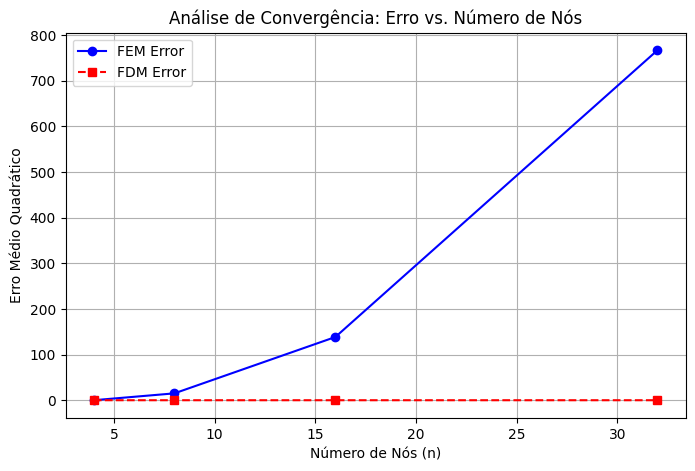

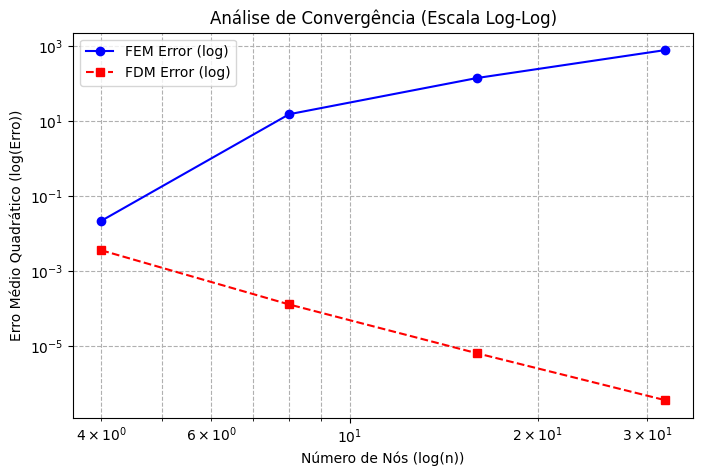

In [6]:
# Análise de convergência.
# %%
# Valores de n para a análise de convergência
n_values = [4, 8, 16, 32]

# Listas para armazenar os erros
errors_fem = []
errors_fdm = []

# Loop sobre os valores de n
for n in n_values:
    # --- FEM ---
    # Resolve o problema com n graus de liberdade internos (dof)
    # O número total de nós para FEM é dof + 1
    dof_fem = n - 2 # Número de graus de liberdade internos
    xi_fem = np.linspace(0,1,dof_fem+2) # Nós para FEM

    # Inicializando as variáveis para FEM
    K_AB_fem = np.zeros([dof_fem, dof_fem])
    F_A_fem = np.zeros(dof_fem)

    # Montando o sistema FEM (mesma lógica do seu código original, adaptada para a função)
    for a in range(dof_fem):
        for b in range(dof_fem):
            K_AB_fem[a,b] = quad(innerprod_a,0,1,args=(xi_fem,a,b))[0]

        F_A_fem[a] = quad(innerprod,0,1,args=(xi_fem,a))[0] + N(0,xi_fem,a)*u_e(1) - u_e(0)*quad(innerprod_a,0,1,args=(xi_fem,a,dof_fem))[0]

    # Construindo o vetor de solução global d (incluindo as condições de contorno)
    d_fem = np.zeros(dof_fem + 2)
    d_fem[0] = u_e(0) # Condição de contorno em x=0
    # Os graus de liberdade internos correspondem aos nós de índice 1 até n_nodes_fem-2
    # A fatia d_fem[1:n_nodes_fem-1] seleciona esses elementos
    d_fem[1:dof_fem+1] = dof_fem
    d_fem[dof_fem+1] = u_e(1) # Condição de contorno em x=1

    # Calculando a solução FEM nos pontos de amostragem (x)
    u_fem_n = np.zeros(np.size(x))
    for i_sample in range(len(x)): # loop over all sample points
        # O loop interno deve ir sobre todos os nós, cujo número é n_nodes_fem
        for j_node in range(dof_fem + 2): # loop over all nodes

            u_fem_n[i_sample] = u_fem_n[i_sample] + N(x[i_sample], xi_fem, j_node) * d_fem[j_node]

    # Calculando a solução analítica nos pontos de amostragem (x)
    u_exact_n = u_e(x)

    # Calculando o erro médio quadrático para FEM
    mse_fem = mean_square_error(u_fem_n, u_exact_n)
    errors_fem.append(mse_fem)

    # --- FDM ---
    # Resolve o problema usando FDM com n nós
    x_fdm_n, u_fdm_n = solve_fdm(n)

    # Para comparar com a solução analítica, precisamos da solução analítica nos mesmos pontos que a FDM
    u_exact_fdm_n = u_e(x_fdm_n)

    # Calculando o erro médio quadrático para FDM
    mse_fdm = mean_square_error(u_fdm_n, u_exact_fdm_n)
    errors_fdm.append(mse_fdm)

# Plotagem dos resultados da análise de convergência.
# %%
fig = plt.figure(figsize=(8,5))
plt.plot(n_values, errors_fem, 'bo-', label='FEM Error');
plt.plot(n_values, errors_fdm, 'rs--', label='FDM Error');
plt.xlabel('Número de Nós (n)');
plt.ylabel('Erro Médio Quadrático');
plt.title('Análise de Convergência: Erro vs. Número de Nós');
plt.legend();
plt.grid(True);

# Opcional: Plotagem em escala logarítmica para visualizar melhor a ordem de convergência
fig_log = plt.figure(figsize=(8,5))
plt.loglog(n_values, errors_fem, 'bo-', label='FEM Error (log)');
plt.loglog(n_values, errors_fdm, 'rs--', label='FDM Error (log)');
plt.xlabel('Número de Nós (log(n))');
plt.ylabel('Erro Médio Quadrático (log(Erro))');
plt.title('Análise de Convergência (Escala Log-Log)');
plt.legend();
plt.grid(True, which="both", ls="--"); # Adiciona grid em ambas as escalas para loglog

plt.show()

Resolvendo Sistema.


 System solution d = 
[ 0.236  0.179  0.119  0.059 -0.006 -0.009 -0.008 -0.013 -0.018 -0.014
 -0.011 -0.011 -0.012 -0.012 -0.011 -0.011 -0.014 -0.019 -0.013 -0.009
 -0.011 -0.007  0.249  0.5    0.751]


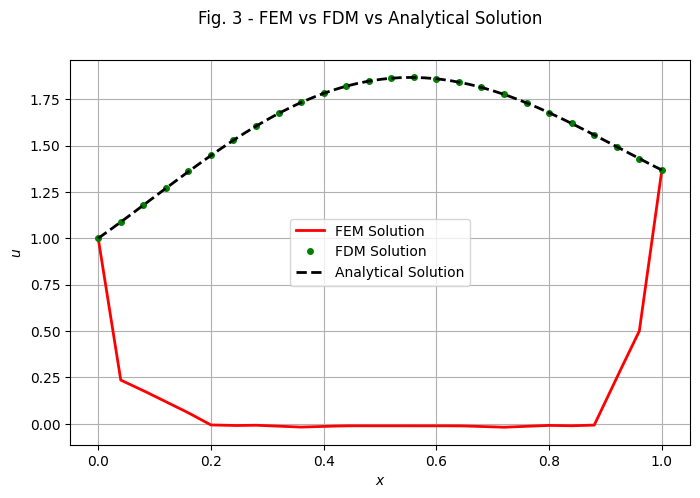

In [8]:
# Resolvendo Sistema e Comparando com FDM e Solução Analítica.
# %%
# solving the linea system (FEM)
d = np.linalg.solve(K_AB, F_A)
print("\n System solution d = ")
print(d)

# Adding d_(n+1) - Condição de contorno em x=1
# O número total de nós para este caso específico é dof + 1
n_nodes_single_plot = dof + 1
d_fem_single_plot = np.zeros(n_nodes_single_plot)
d_fem_single_plot[0] = u_e(0) # Condição de contorno em x=0
# Os graus de liberdade internos correspondem aos nós de índice 1 até dof
# A fatia correta é de 1 até dof (inclusive)
d_fem_single_plot[1:dof+1] = d # MODIFICAÇÃO AQUI: dof+1 no limite superior da fatia
d_fem_single_plot[n_nodes_single_plot - 1] = u_e(1) # Condição de contorno em x=1

# Calculando a solução FEM nos pontos de amostragem (x)
u_fem = np.zeros(np.size(x))
# O número total de nós para este caso específico é dof + 1
xi_single_plot = np.linspace(0, 1, n_nodes_single_plot) # Nós para a plotagem FEM
for i in range(len(x)): # loop over all sample points
    # O loop interno deve ir sobre todos os nós, cujo número é n_nodes_single_plot
    for j in range(n_nodes_single_plot): # loop over all nodes
        u_fem[i] = u_fem[i] + N(x[i], xi_single_plot, j) * d_fem_single_plot[j]

# --- Solução Analítica (para plotagem) ---
u_exact = u_e(x)

# --- Solução FDM (para plotagem) ---
# Usar o mesmo número de nós que o FEM nesta seção
x_fdm_single_plot, u_fdm_single_plot = solve_fdm(n_nodes_single_plot)
# Solução analítica nos pontos FDM para comparação
u_exact_fdm_single_plot = u_e(x_fdm_single_plot)


#ploting solution.
fig = plt.figure(figsize=(8,5))
plt.plot(x, u_fem, 'r', linewidth=2, label='FEM Solution');
plt.plot(x_fdm_single_plot, u_fdm_single_plot, 'g.', markersize=8, label='FDM Solution'); # Plotagem da solução FDM
plt.plot(x, u_exact, 'k--', linewidth=2, label='Analytical Solution');
plt.grid(True);
plt.xlabel('$x$');
plt.ylabel('$u$');
plt.legend()
fig.suptitle('Fig. 3 - FEM vs FDM vs Analytical Solution');

plt.show() # Adiciona plt.show() para garantir que o gráfico seja exibido
